# DATA

In [74]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import scipy  

### Read the JSON datafiles

In [75]:
# specify path to file for biased results 
path_bias = 'results/data_biased.json'

# specify path to file for debiased results in case of one file
path_debias = 'results/data_debias.json'

# specify paths to files for debiased results in case of two separate files
# set bool to True in order to use this
two_files = True
path1_debias = 'results/data_debias_first.json'
path2_debias = 'results/data_debias_second.json'

In [76]:
def read_json(path):
    with open(path, 'r', encoding='utf8') as f:
        json_dict = json.load(f)
    return json_dict

def concat_json(json1, json2): 
    json = defaultdict(lambda: defaultdict(list))
    for setting in json1.keys(): 
        for key in json1[setting].keys():
            json[setting][key] = json1[setting][key] + json2[setting][key]
    return json

In [77]:
# load data 
results_bias = read_json(path_bias)

if two_files:
    results_debias = concat_json(read_json(path1_debias), read_json(path2_debias))
else: 
    read_json(path_debias)

## Hyperparameter search
Find best setting if the result file contains multiple hyperparameter settings

In [53]:
def search_setting(results, debiased=True, tolerance=0.05): 

    if debiased:
        print("\n-------with debias-------")
    else: 
        print("\n-------without debias-------")

    best_acc = (0, 0)
    for setting in results.keys():
        neg_fpr = (np.mean(results[setting]['neg_fpr']), np.std(results[setting]['neg_fpr']))
        neg_fnr = (np.mean(results[setting]['neg_fnr']), np.std(results[setting]['neg_fnr']))
        pos_fpr = (np.mean(results[setting]['pos_fpr']), np.std(results[setting]['neg_fnr']))
        pos_fnr = (np.mean(results[setting]['pos_fnr']), np.std(results[setting]['neg_fnr']))
        if debiased:
            if np.abs(neg_fnr[0] - pos_fnr[0]) < tolerance and np.abs(neg_fpr[0] - pos_fpr[0]) < tolerance:
                print('Setting {} -> Neg FPR: {:.5f} +- {:.5f}, Pos FPR: {:.5f} +- {:.5f}, Neg FNR: {:.5f} +- {:.5f}, Pos FNR: {:.5f} +- {:.5f}, pred acc: {:.5f} +-{:.5f}'.format(setting, neg_fpr[0], neg_fpr[1], pos_fpr[0], pos_fpr[1], neg_fnr[0], neg_fnr[1], pos_fnr[0],  pos_fnr[1], best_acc[0], best_acc[1]))
            else:
                continue

        acc = (np.mean(results[setting]['predictor_acc']), np.std(results[setting]['predictor_acc']))
        if acc[0] > best_acc[0]:
            best_acc = acc
            best_setting = setting


    print("\nBEST SETTING:")
    print('Setting {} -> Neg FPR: {:.5f} +- {:.5f}, Pos FPR: {:.5f} +- {:.5f}, Neg FNR: {:.5f} +- {:.5f}, Pos FNR: {:.5f} +- {:.5f}, pred acc: {:.5f} +-{:.5f}'.format(best_setting, neg_fpr[0], neg_fpr[1], pos_fpr[0], pos_fpr[1], neg_fnr[0], neg_fnr[1], pos_fnr[0],  pos_fnr[1], best_acc[0], best_acc[1]))
    print()

    return best_setting

In [54]:
# run to obtain the best hyperparameter settings
best_setting_biased = search_setting(results_bias, debiased=False)
best_setting_debiased = search_setting(results_debias)


-------without debias-------

BEST SETTING:
Setting (0.01, 0.01, 64) -> Neg FPR: 0.03912 +- 0.01512, Pos FPR: 0.12344 +- 0.08800, Neg FNR: 0.49305 +- 0.08800, Pos FNR: 0.41302 +- 0.08800, pred acc: 0.83868 +-0.00082


-------with debias-------
Setting (0.01, 0.001, 32) -> Neg FPR: 0.05763 +- 0.04737, Pos FPR: 0.08691 +- 0.32580, Neg FNR: 0.60169 +- 0.32580, Pos FNR: 0.63314 +- 0.32580, pred acc: 0.00000 +-0.00000
Setting (0.01, 0.001, 128) -> Neg FPR: 0.07667 +- 0.06475, Pos FPR: 0.12580 +- 0.32449, Neg FNR: 0.51492 +- 0.32449, Pos FNR: 0.52736 +- 0.32449, pred acc: 0.79388 +-0.02570
Setting (0.01, 0.01, 128) -> Neg FPR: 0.07626 +- 0.05858, Pos FPR: 0.10155 +- 0.32098, Neg FNR: 0.51644 +- 0.32098, Pos FNR: 0.56265 +- 0.32098, pred acc: 0.79437 +-0.02898
Setting (0.01, 0.1, 128) -> Neg FPR: 0.03968 +- 0.04986, Pos FPR: 0.05988 +- 0.32924, Neg FNR: 0.73153 +- 0.32924, Pos FNR: 0.74450 +- 0.32924, pred acc: 0.79870 +-0.02581
Setting (0.1, 0.0001, 64) -> Neg FPR: 0.00874 +- 0.01745, Pos F

## Data Analysis

#### Input the settings you want to run the analysis for

In [69]:
setting_biased  = "(0.01, 0.01, 64)"
setting_debiased = "(0.01, 0.01, 128)"

### Plot the results 

In [70]:
def plot_results(results_bias, results_debias):

    plt.style.use('seaborn-whitegrid')

    new_style = {'grid': False}
    plt.rc('axes', **new_style)


    bar_width = 0.25
    r1 = [0, 0.7]
    r2 = [x + bar_width for x in r1]

    fig, axs = plt.subplots(1, 2)


    # plot results FNR
    women_mean = (np.mean(results_bias["neg_fnr"]), np.mean(results_debias["neg_fnr"]))
    men_mean = (np.mean(results_bias["pos_fnr"]), np.mean(results_debias["pos_fnr"]))
    women_std = (np.std(results_bias["neg_fnr"]), np.std(results_debias["neg_fnr"]))
    men_std = (np.std(results_bias["pos_fnr"]), np.std(results_debias["pos_fnr"]))

    axs[0].bar(r1, women_mean, color='#FF00B2', width=bar_width, yerr=women_std, error_kw=dict(lw=0.7, capsize=4, capthick=0.7, ecolor="#505050"), edgecolor='white', label='Women')
    axs[0].bar(r2, men_mean, color='#0097FF', width=bar_width, yerr=men_std, error_kw=dict(lw=0.7, capsize=4, capthick=0.7, ecolor="#505050"), edgecolor='white', label='Men')

    # plot FNR results Zhang et al 
    axs[0].plot([r1[0]-0.5*bar_width +0.005, r1[0]+0.5*bar_width], [0.4492, 0.4492], "k:", lw=2, label="Zhang et al. (2018)")
    axs[0].plot([r1[1]-0.5*bar_width +0.005, r1[1]+0.5*bar_width], [0.4458, 0.4458], "k:", lw=2)
    axs[0].plot([r2[0]-0.5*bar_width +0.005, r2[0]+0.5*bar_width], [0.3667, 0.3667], "k:", lw=2)
    axs[0].plot([r2[1]-0.5*bar_width +0.005, r2[1]+0.5*bar_width], [0.4349, 0.4349], "k:", lw=2)

    axs[0].set_xlabel('FNR', fontsize=11)
    axs[0].set_xticks([r + bar_width/2 for r in r1])
    axs[0].set_xticklabels(['Without debias', 'With debias'])
    # plt.yticks(np.arange(0, 0.7, 0.1))
    axs[0].set_ylabel('Rate')
    axs[0].legend(loc="upper left")


    # plot results FPR
    women_mean = (np.mean(results_bias["neg_fpr"]), np.mean(results_debias["neg_fpr"]))
    men_mean = (np.mean(results_bias["pos_fpr"]), np.mean(results_debias["pos_fpr"]))
    women_std = (np.std(results_bias["neg_fpr"]), np.std(results_debias["neg_fpr"]))
    men_std = (np.std(results_bias["pos_fpr"]), np.std(results_debias["pos_fpr"]))

    # plot FPR results Zhang et al 
    axs[1].bar(r1, women_mean, color='#FF00B2', width=bar_width, yerr=women_std, error_kw=dict(lw=0.7, capsize=4, capthick=0.7, ecolor="#505050"), edgecolor='white', label='Women')
    axs[1].bar(r2, men_mean, color='#0097FF', width=bar_width, yerr=men_std, error_kw=dict(lw=0.7, capsize=4, capthick=0.7, ecolor="#505050"), edgecolor='white', label='Men')
    axs[1].plot([r1[0]-0.5*bar_width +0.005, r1[0]+0.5*bar_width], [0.0248, 0.0248],"k:", lw=2, label="Zhang et al.")
    axs[1].plot([r1[1]-0.5*bar_width +0.005, r1[1]+0.5*bar_width], [0.0647, 0.0647], "k:", lw=2)
    axs[1].plot([r2[0]-0.5*bar_width +0.005, r2[0]+0.5*bar_width], [0.0917, 0.0917], "k:", lw=2)
    axs[1].plot([r2[1]-0.5*bar_width +0.005, r2[1]+0.5*bar_width], [0.0701, 0.0701], "k:", lw=2)

    axs[1].set_xlabel('FPR', fontsize=11)
    axs[1].set_xticks([r + bar_width/2 for r in r1])
    axs[1].set_xticklabels(['Without debias', 'With debias'])	

    plt.tight_layout()
    plt.show()

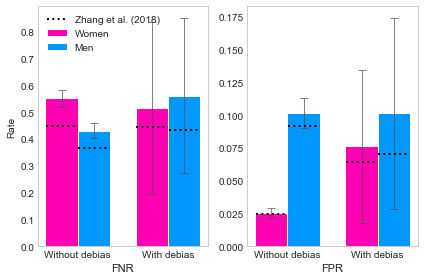

In [71]:
plot_results(results_bias[setting_biased], results_debias[setting_debiased])

### Perform statistical analysis

In [72]:
def statistical_analysis(results_bias, results_debias, alpha=0.05):

    results_bias.pop('neg_confusion_mat', None)
    results_bias.pop('pos_confusion_mat', None)
    results_debias.pop('neg_confusion_mat', None)
    results_debias.pop('pos_confusion_mat', None)


    # test if assumption of normally distributed dataset is voilated
    print("\nTest assumption of normally distribution")
    normal_distr = True
    for key in results_bias.keys(): 
        for i, dataset in enumerate([results_bias, results_debias]):

            data_name = "biased" if i == 0  else "debiased"
            _, p_value_s = scipy.stats.shapiro(dataset[key])
            print("%s shapiro %s, %.5f" %(data_name, key, p_value_s))
            # plt.hist(dataset[key])
            # plt.show()

            if p_value_s < alpha:
                normal_distr = False

    if not normal_distr:
        print("Assumption normal distribution is violated")

    compare = [("neg_fnr", "pos_fnr"), ("neg_fpr", "pos_fpr")] 

    # test if assumption of equal variance is violated
    print("\nTest assumption of equal variance")
    equal_var = True
    for c1, c2 in compare: 
        for i, dataset in enumerate([results_bias, results_debias]):

            data_name = "biased" if i == 0  else "debiased"

            __, p_value_l = scipy.stats.levene(results_bias[c1], results_bias[c2])
            print("%s levene %s vs. %s: %.5f" %(data_name, c1, c2, p_value_l))

            if p_value_l < alpha: 
                equal_var = False

    if not equal_var: 
        print("Assumption equal variance is violated")


    # pick appropriate statiscal test
    if not normal_distr or equal_var:
        stat_test = scipy.stats.mannwhitneyu
        print("\nPerform Mann-Whitney U test")
    else: 
        stat_test = scipy.stats.ttest_ind
        print("\nPerform two-sided t-test")

    # execute statistical test 
    for c1, c2 in compare: 
        for i, dataset in enumerate([results_bias, results_debias]):
            data_name = "biased" if i == 0  else "debiased"
            __, p_value = stat_test(dataset[c1], dataset[c2])

            print("%s: %s vs. %s: %.10f" %(data_name, c1, c2, p_value))
    print("\n")


In [73]:
statistical_analysis(results_bias[setting_biased], results_debias[setting_debiased])


Test assumption of normally distribution
biased shapiro neg_fpr, 0.00367
debiased shapiro neg_fpr, 0.33088
biased shapiro neg_fnr, 0.02139
debiased shapiro neg_fnr, 0.00193
biased shapiro pos_fpr, 0.69154
debiased shapiro pos_fpr, 0.09190
biased shapiro pos_fnr, 0.49491
debiased shapiro pos_fnr, 0.00160
biased shapiro predictor_acc, 0.21593
debiased shapiro predictor_acc, 0.04127
Assumption normal distribution is violated

Test assumption of equal variance
biased levene neg_fnr vs. pos_fnr: 0.72183
debiased levene neg_fnr vs. pos_fnr: 0.72183
biased levene neg_fpr vs. pos_fpr: 0.04770
debiased levene neg_fpr vs. pos_fpr: 0.04770
Assumption equal variance is violated

Perform Mann-Whitney U test
biased: neg_fnr vs. pos_fnr: 0.0000903174
debiased: neg_fnr vs. pos_fnr: 0.1789716092
biased: neg_fpr vs. pos_fpr: 0.0000898113
debiased: neg_fpr vs. pos_fpr: 0.1417462899


